In [48]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
import time
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)
df_data = pd.read_csv("alldata.csv", header=0)
df_data = df_data.dropna()
df_data = df_data.drop(df_data[df_data['Exploitable'] == 0].index)

In [3]:
list_vitesse = []
for i in df_data['Vitesse']:
    list_vitesse.append(eval(i))

list_frf_reel = []
for i in df_data['FRF réel']:
    list_frf_reel.append(eval(i))

list_frf_imag = []
for i in df_data['FRF imag']:
    list_frf_imag.append(eval(i))

In [4]:
np_vitesse = np.array(list_vitesse)
np_frf_reel = np.array(list_frf_reel)
np_frf_imag = np.array(list_frf_imag)
np_frf = np.sqrt(np.square(np_frf_reel) + np.square(np_frf_imag))

In [5]:
np_classe = df_data['Niveau'].values
np_classe = pd.get_dummies(np_classe).values


In [6]:
np_data = np.concatenate((np_vitesse, np_frf, np_classe), axis=1)
np.random.shuffle(np_data)

In [7]:
np_vitesse = np_data[:, :614]
np_frf = np_data[:, 614:1228]
np_classe = np_data[:, 1228:]

In [8]:
ts_vitesse = torch.tensor(np_vitesse, dtype=torch.float32).reshape(np_vitesse.shape[0], 1, np_vitesse.shape[1])
ts_frf = torch.tensor(np_frf, dtype=torch.float32).reshape(np_frf.shape[0], 1, np_frf.shape[1])
ts_classe = torch.tensor(np_classe, dtype=torch.float32)

In [26]:
ts_feature = torch.concat((ts_vitesse, ts_frf), dim=1)

In [49]:
threshold1 = int(0.6*ts_feature.shape[0])
threshold2 = int(0.8*ts_feature.shape[0])
X_train_v = ts_vitesse[:threshold1]
X_train = ts_feature[:threshold1]
Y_train = ts_classe[:threshold1]
X_valid_v = ts_vitesse[threshold1:threshold2]
X_valid = ts_feature[threshold1:threshold2]
Y_valid = ts_classe[threshold1:threshold2]
X_test_v = ts_vitesse[threshold2:]
X_test = ts_feature[threshold2:]
Y_test = ts_classe[threshold2:]

In [52]:
net_v_lenet = nn.Sequential(
              nn.Conv1d(1, 6, kernel_size=5, stride=2,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Conv1d(6, 16, kernel_size=5,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(1216, 120), nn.ReLU(),
              nn.Linear(120, 84), nn.ReLU(),
              nn.Linear(84, 5))

In [53]:
X = torch.rand(size=(1, 1, 614), dtype=torch.float32)
for layer in net_v_lenet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv1d output shape: 	 torch.Size([1, 6, 307])
ReLU output shape: 	 torch.Size([1, 6, 307])
MaxPool1d output shape: 	 torch.Size([1, 6, 153])
Conv1d output shape: 	 torch.Size([1, 16, 153])
ReLU output shape: 	 torch.Size([1, 16, 153])
MaxPool1d output shape: 	 torch.Size([1, 16, 76])
Flatten output shape: 	 torch.Size([1, 1216])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 5])


In [54]:
net_lenet = nn.Sequential(
            nn.Conv1d(2, 6, kernel_size=5, stride=2,
                    padding=2), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(6, 16, kernel_size=5,
                    padding=2), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(1216, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 5))

In [56]:
X = torch.rand(size=(1, 2, 614), dtype=torch.float32)
for layer in net_lenet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv1d output shape: 	 torch.Size([1, 6, 307])
ReLU output shape: 	 torch.Size([1, 6, 307])
MaxPool1d output shape: 	 torch.Size([1, 6, 153])
Conv1d output shape: 	 torch.Size([1, 16, 153])
ReLU output shape: 	 torch.Size([1, 16, 153])
MaxPool1d output shape: 	 torch.Size([1, 16, 76])
Flatten output shape: 	 torch.Size([1, 1216])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 5])


In [57]:
class Residual1d(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1 +batchnorm + relu
        Y = self.bn2(self.conv2(Y))  # conv2 + batchnorm
        if self.conv3:
            X = self.conv3(X)
        Y += X   # residual + base
        return F.relu(Y)

def resnet_block1d(input_channels, num_channels, num_residuals,
                   first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1d(input_channels, num_channels,
                                  use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1d(num_channels, num_channels))
    return blk

# stage1, length / 2
b1 = nn.Sequential(nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b2 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b3 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b4 = nn.Sequential(*resnet_block1d(32, 64, 2))
b5 = nn.Sequential(*resnet_block1d(64, 128, 2))
net_resnet = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 5))

In [58]:
X = torch.rand(size=(1, 2, 614), dtype=torch.float32)
for layer in net_resnet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Sequential output shape: 	 torch.Size([1, 16, 154])
Sequential output shape: 	 torch.Size([1, 16, 154])
Sequential output shape: 	 torch.Size([1, 32, 77])
Sequential output shape: 	 torch.Size([1, 64, 39])
Sequential output shape: 	 torch.Size([1, 128, 20])
AdaptiveAvgPool1d output shape: 	 torch.Size([1, 128, 1])
Flatten output shape: 	 torch.Size([1, 128])
Linear output shape: 	 torch.Size([1, 5])


In [59]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [60]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [61]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

In [62]:
def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [63]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 20, 1e-3, 0, 64, try_gpu()

loss 0.329, train acc 0.869, test acc 0.851
4502.8 examples/sec on cuda:0


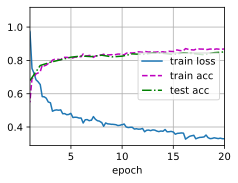

In [64]:
train_accuracy(net_v_lenet, X_train_v, Y_train, X_valid_v, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

loss 0.138, train acc 0.942, test acc 0.908
4983.7 examples/sec on cuda:0


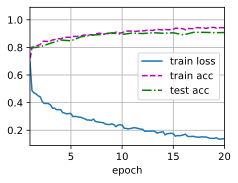

In [65]:
train_accuracy(net_lenet, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

loss 0.082, train acc 0.968, test acc 0.938
1919.9 examples/sec on cuda:0


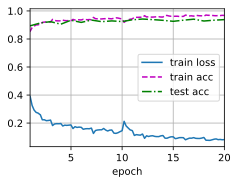

In [66]:
train_accuracy(net_resnet, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [68]:
net_v_lenet.cpu()
net_lenet.cpu()
net_resnet.cpu()
Y_pred_v = net_v_lenet(X_test_v)
Y_pred_le = net_lenet(X_test)
Y_pred_res = net_resnet(X_test)

In [69]:
np_Y_pred_v = Y_pred_v.argmax(axis=1).numpy()
np_Y_pred = Y_pred_le.argmax(axis=1).numpy()
np_Y_pred_res = Y_pred_res.argmax(axis=1).numpy()
np_Y_test = Y_test.argmax(axis=1).numpy()

In [70]:
cm1 = confusion_matrix(np_Y_test, np_Y_pred_v)
cm2 = confusion_matrix(np_Y_test, np_Y_pred)
cm3 = confusion_matrix(np_Y_test, np_Y_pred_res)

In [83]:
cm1 / np.sum(cm1, axis=1).reshape(-1, 1)

array([[9.02576996e-01, 9.49088624e-02, 6.28535512e-04, 1.88560654e-03,
        0.00000000e+00],
       [9.43025540e-02, 8.69842829e-01, 3.24165029e-02, 3.43811395e-03,
        0.00000000e+00],
       [3.60360360e-02, 3.89639640e-01, 5.67567568e-01, 6.75675676e-03,
        0.00000000e+00],
       [7.31707317e-02, 5.36585366e-01, 1.46341463e-01, 2.43902439e-01,
        0.00000000e+00],
       [1.11111111e-01, 5.55555556e-01, 0.00000000e+00, 3.33333333e-01,
        0.00000000e+00]])

In [84]:
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1).reshape(-1, 1), range(5), range(5))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

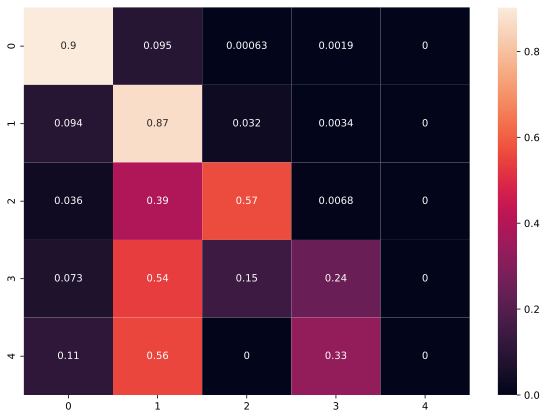

In [85]:
plot_confusion_matrix(cm1)

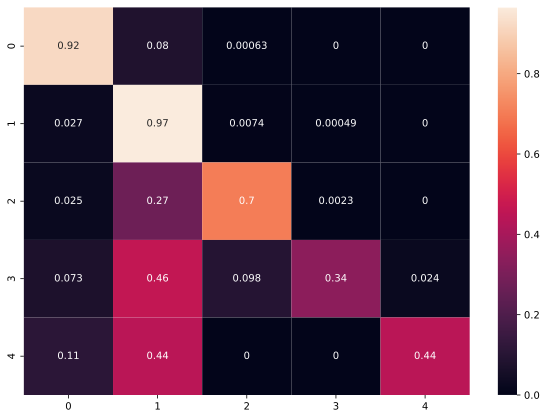

In [86]:
plot_confusion_matrix(cm2)

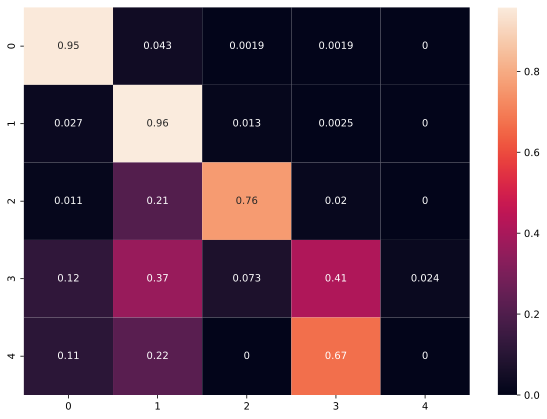

In [87]:
plot_confusion_matrix(cm3)